# Prerequisities

In [19]:
pip install arff numpy pandas matplotlib sklearn tensorflow_addons

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Import libraries

In [13]:
from scipy.io import arff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import tensorflow_addons as tfa
import tensorflow as tf

# Load the same dataset distribution

In [3]:
X_train = np.genfromtxt('dataset-distribution/x_train_fold_6.csv', delimiter=',')
Y_train = np.genfromtxt('dataset-distribution/y_train_fold_6.csv', delimiter=',')
X_test = np.genfromtxt('dataset-distribution/x_test_fold_6.csv', delimiter=',')
Y_test = np.genfromtxt('dataset-distribution/y_test_fold_6.csv', delimiter=',')

# Load the MLP model

In [8]:
with open('models/boosted_model.pkl', 'rb') as f:
    mlp = pickle.load(f)

Y_pred = mlp.predict(X_test)

# R2 value
print("R-squared: ", mlp.score(X_test, Y_test))

# Loss value
mse = tf.keras.metrics.MeanSquaredError()
mse.update_state(Y_test, Y_pred.ravel())
print("MSE: ", mse.result().numpy())

1/1 [==============================] - 0s 15ms/step
R-squared:  0.9699026466859687
MSE:  0.025950752


# K-Nearest Neighbour Regression

The K-Nearest Neighbor Regression is a simple algorithm that stores all available cases and predict the numerical target based on a similarity measure and it’s been used in a statistical estimation and pattern recognition as non-parametric technique classifying correctly unknown cases calculating euclidean distance between data points. In fact our choice by K-Nearest Neighbor Regression was motivated by the absence of a detailed explanation about how effort attribute value is calculated on Desharnais dataset. In the K-Nearest Neighbor Regression we choose to specify only 3 neighbors for k-neighbors queries and uniform weights, that means all points in each neighborhood are weighted equally.

In [9]:
knn = KNeighborsRegressor(n_neighbors=3, weights='uniform')
knn.fit(X_train, Y_train) 

# R2 value
print("R-squared: ", knn.score(X_test, Y_test))

# Loss value
mse = tf.keras.metrics.MeanSquaredError()
Y_pred = knn.predict(X_test)
mse.update_state(Y_test, Y_pred.ravel())
print("MSE: ", mse.result().numpy())

R-squared:  0.6710262751034497
MSE:  0.28365004


# Linear Regression

The regression analysis aims to verify the existence of a functional relationship between a variable with one or more variables, obtaining an equation that explains the variation of the dependent variable Y, by the variation of the levels of the independent variables. The training of the Linear Regression model consists of generating a regression for the target variable Y.

In [10]:
lr = LinearRegression()
lr.fit(X_train, Y_train)

# R2 value
print("R-squared: ", lr.score(X_test, Y_test))

# Loss value
mse = tf.keras.metrics.MeanSquaredError()
Y_pred = lr.predict(X_test)
mse.update_state(Y_test, Y_pred.ravel())
print("MSE: ", mse.result().numpy())

R-squared:  0.9521635964906143
MSE:  0.04124584


# Support Vector Machine

In [11]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1,2,3,4,5,6,7,8,9,10], 'gamma':('auto', 'scale')}

svr = SVR()
LinearSVC = GridSearchCV(svr, parameters, cv=3)
LinearSVC.fit(X_train, Y_train.ravel())
print("Best params hash: {}".format(LinearSVC.best_params_))

# R2 value
print("R-squared: ", LinearSVC.score(X_test, Y_test))

# Loss value
mse = tf.keras.metrics.MeanSquaredError()
Y_pred = LinearSVC.predict(X_test)
mse.update_state(Y_test, Y_pred.ravel())
print("MSE: ", mse.result().numpy())

Best params hash: {'C': 1, 'gamma': 'auto', 'kernel': 'linear'}
R-squared:  0.8675210129891948
MSE:  0.11422697


# Random forest

In [29]:
metric = tfa.metrics.r_square.RSquare()

# for i in np.arange(100,1100,100):
rf = RandomForestRegressor(n_estimators=i,max_features=5)
rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_test)

# R-squared value
metric.update_state(Y_test, Y_pred.ravel())
print("R-squared: ", metric.result().numpy())

# Loss value
print("MSE: ", np.sqrt(mean_squared_error(Y_test, Y_pred)))

R-squared:  0.70327944
MSE:  0.5058067963472457


# Results

The figure shows the linear model (blue line) prediction is fairly close to Knn model effort prediction (red line), predicting the numerical target based on a similarity measure. According to the plot we observe that Linear Regression model (blue line) presents a better performance. Although Knn Regression model (red line) is fairly close to data points, the Linear Regression model shows a smaller mean squared error. It is possible to observe that the lines of both models present a slight tendency to rise, which justifies their correlation with the increase in effort. Some metrics are also highlighted by the presence of outliers.

In [18]:
data_frame = pd.read_csv('datasets/desharnais.csv', header=0)
features = [ 'TeamExp', 'ManagerExp', 'YearEnd', 'Length', 'Transactions', 'Entities',
        'PointsNonAdjust', 'Adjustment', 'PointsAjust']

core_features = ['Length', 'Transactions', 'Entities','PointsNonAdjust','PointsAjust']

X = data_frame[features]
Y = data_frame['Effort']

1/1 [==============================] - 0s 16ms/step


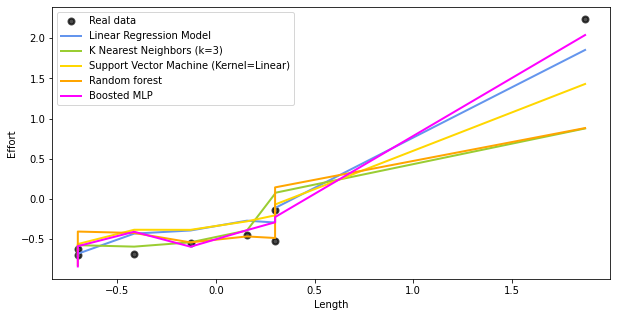

1/1 [==============================] - 0s 14ms/step


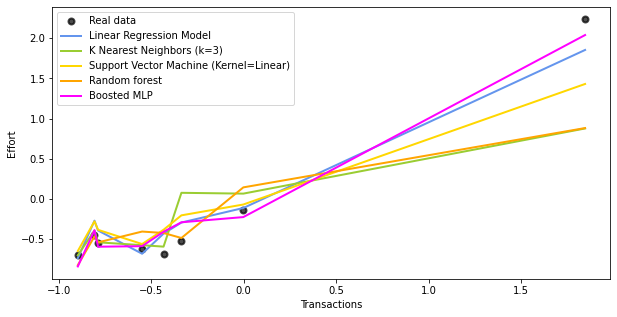

1/1 [==============================] - 0s 18ms/step


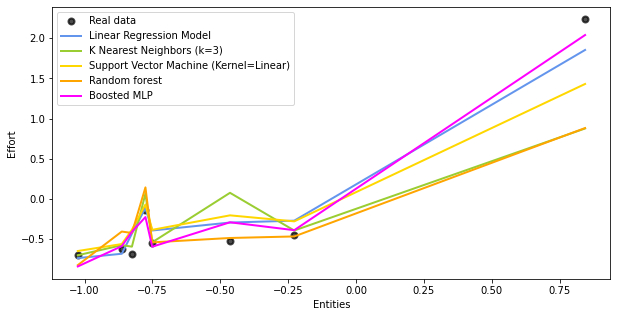

1/1 [==============================] - 0s 14ms/step


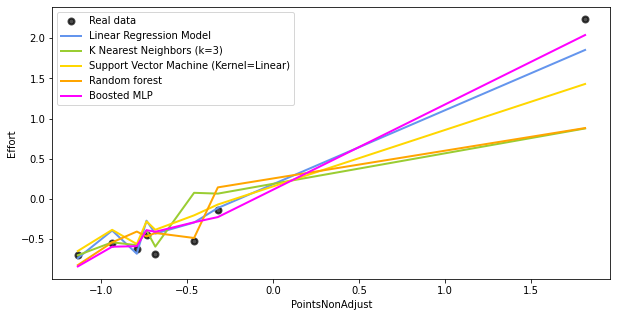

1/1 [==============================] - 0s 16ms/step


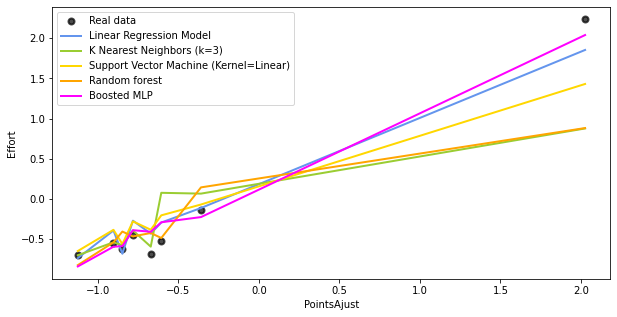

In [32]:
for i, feature in enumerate(core_features):
    plt.figure(figsize=(10,5))
    
    X_df = pd.DataFrame(X_test, columns = core_features)

    # Knn Regression Model 
    knn_xs, knn_ys = zip(*sorted(zip(X_df[feature], knn.predict(X_test))))
    
    # Linear Regression Model 
    lr_xs, lr_ys = zip(*sorted(zip(X_df[feature], lr.predict(X_test))))
    
    # Support Vector Machine
    svm_xs, svm_ys = zip(*sorted(zip(X_df[feature], LinearSVC.predict(X_test))))
    
    # Random forest
    rf_xs, rf_ys = zip(*sorted(zip(X_df[feature], rf.predict(X_test))))
    
    # Multi-layer perceptron
    mlp_xs, mlp_ys = zip(*sorted(zip(X_df[feature], mlp.predict(X_test))))

    plt.scatter(X_df[feature], Y_test, label = 'Real data', lw = 2, alpha = 0.7, c = 'k' )
    plt.plot(lr_xs, lr_ys , lw=2, label='Linear Regression Model', c='cornflowerblue')
    plt.plot(knn_xs, knn_ys , lw=2,label='K Nearest Neighbors (k=3)', c='yellowgreen')
    plt.plot(svm_xs, svm_ys , lw=2,label='Support Vector Machine (Kernel=Linear)', c='gold')
    plt.plot(rf_xs, rf_ys , lw=2,label='Random forest', c='orange')
    plt.plot(mlp_xs, mlp_ys , lw=2,label='Boosted MLP', c='magenta')
    
    plt.xlabel(feature)
    plt.ylabel('Effort')
    plt.legend()
    plt.show()